# Analysis #9: Making the Tree figure summarizing the findings about oskar evolution
- Author: Leo Blondel
- Creation: 10-01-2019
- Last modification: 10-24-2019

### Description
Generates Figure 3 where Oskar identification statistics across insect orders were plotted with tissue and developmental stage information. Initial phylogenetic tree was first published by _Misof et al. - Phylogenomics resolves the timing and pattern of insect evolution (Science, 2014); <url>https://doi.org/10.1126/science.1257570</url>_

#### Imports

In [1]:
import os
os.environ['QT_QPA_PLATFORM']='offscreen'

import ete3
from Bio import SeqIO
import numpy as np
import pandas as pd
from colors import colors
colormap = colors()

# Generating the metadata dataframe

## Defining Helper functions

In [2]:
def genome_type(x):
    if 'GCA' in x:
        return "GCA"
    elif 'GCF' in x:
        return 'GCF'
    else:
        return ""

## Making the metadata DataFrame

In [3]:
search_metadata = pd.read_csv('../Data/01_Oskar_identification/oskar_tracker_results/search_results.csv')

In [4]:
metadatas = search_metadata.groupby(['order_name', 'source'], as_index=False).sum()
tmp2 = search_metadata.groupby(['order_name', 'source'], as_index=False).count()
metadatas['index'] = tmp2['index']
metadatas['found_prop'] = metadatas['filtered_hits']/metadatas['index']

In [5]:
transcritpome_crustacea = pd.read_csv('../Data/01_Oskar_identification/2017/transcriptome_crustacean_database.csv')
genome_crustacea = pd.read_csv('../Data/01_Oskar_identification/2017/genome_crustacean_database.csv')
genome_crustacea['type'] = genome_crustacea['genome_id'].map(genome_type)
crust = [
    ['Crustacea', 'TSA', len(transcritpome_crustacea), 0, 0.0, 0.0],
    ['Crustacea', 'GCF', len(genome_crustacea[genome_crustacea['type'] == 'GCF']), 0, 0.0, 0.0],
    ['Crustacea', 'GCA', len(genome_crustacea[genome_crustacea['type'] == 'GCA']), 0, 0.0, 0.0],
]
crust = pd.DataFrame(crust, columns=metadatas.columns)

In [6]:
metadatas = metadatas.append(crust)

In [7]:
tissue_stage_data = pd.read_csv('../Data/02_Oskar_analyses/2.3/tissue_stage_binned.csv')

In [8]:
tmp = search_metadata[search_metadata['source'] == 'TSA'].merge(tissue_stage_data, left_on='id', right_on='TSA')
tmp = tmp[tmp['hits'] > 0].groupby('order_name_x', as_index=False).sum()
tmp['order_name'] = tmp['order_name_x']
tmp = tmp[['order_name', 'brain', 'germline', 'egg', 'larvae', 'pupae', 'juvenil', 'adult']]
tmp.at[9, 'brain'] = 1
tissue_stage_data = tmp

In [9]:
misof_tree = ete3.Tree("../Data/insect_phylogeny.newick")

In [10]:
# Define the style for the Oskar Origin node
nstyle = ete3.NodeStyle()
nstyle["shape"] = "circle"
nstyle["size"] = 10
nstyle["fgcolor"] = "darkred"

#Find the oskar origin by looking at the Common Ancestor of all the orders
oskar_origin = misof_tree.get_common_ancestor([x.strip() for x in metadatas[metadatas['filtered_hits'] > 0]['order_name'].unique()])

#Set the Oskar origin node Style
oskar_origin.set_style(nstyle)

In [38]:
def r_to_g(value):
    value = float(value)
    if value == 0:
        r = int((1-value) * 255)
    else:
        r = 0
    g = min(120, int(value * 255))
    return '#%02x%02x%02x' % (r, g, 0)

def count_face(node, col):
    if node.name in metadatas['order_name'].values:
        tmp = metadatas.groupby('order_name', as_index=False).sum()

        count = tmp[(tmp['order_name'] == node.name)]['index'].values[0]
        
        T = ete3.TextFace(count, fsize=12, fgcolor='black')
        T.margin_left = 5
        T.hz_align = 1
        ete3.faces.add_face_to_node(T, node, col, aligned=True)
        
    return col + 1

def total_oskar_found_face(node, col):
    if node.name in metadatas['order_name'].values:
        tmp = metadatas.groupby('order_name',as_index=False).sum()
        tmp['found_prop'] = tmp['filtered_hits'] / tmp['index']
        prop = tmp[tmp['order_name'] == node.name]['found_prop'].values[0]
        count = tmp[tmp['order_name'] == node.name]['filtered_hits'].values[0]
        if prop != 0:
            color = colormap.order(node.name)
            colors = [color, colormap.gray]
            percents = [100*prop, (1-prop)*100]
            text_color = "black"
        else:
            colors = [colormap.light_gray]
            percents = [100]
            text_color = colormap.gray
        F = ete3.StackedBarFace(percents, 70, 20, colors=colors, line_color=None)
        F.margin_left = 15
        F.hz_align=0
        ete3.faces.add_face_to_node(F, node, col, aligned=True)
#         T = ete3.TextFace("{} | {}%".format(int(count), int(prop*100)), fgcolor=text_color)
#         T.margin_left = 15
#         T.hz_align=2
#         ete3.faces.add_face_to_node(T, node, col, aligned=True)
    return col + 1
    
def color_code_face(node, col):
    color = colormap.order(node.name)
    F = ete3.RectFace(20, 22, color, color)
    F.margin_left = 5
    F.margin_top=2
    
    ete3.faces.add_face_to_node(F, node, col, aligned=True)
    F = ete3.RectFace(20, 22, color, color)
    F.margin_left = 5
    F.margin_bottom=2
    ete3.faces.add_face_to_node(F, node, col, aligned=True)
    return col + 1

def pie_face(node, source, col):
    tmp = metadatas[metadatas['source'] == source]
    if node.name in tmp['order_name'].values:
        prop = tmp[tmp['order_name'] == node.name]['found_prop'].values[0]
        count = tmp[tmp['order_name'] == node.name]['filtered_hits'].values[0]
        color = colormap.order(node.name)
        percents = [prop*100, (1-prop)*100]
        if prop != 0:
            colors = [color, colormap.gray]
            text_color = "black"
        else:
            colors = [color, colormap.light_gray]
            text_color = colormap.gray
        F = ete3.PieChartFace(percents, 20, 20, colors=colors, line_color=None)
        F.margin_left = 5
        F.hz_align=1
        ete3.faces.add_face_to_node(F, node, col, aligned=True)
#         T = ete3.TextFace("{} | {}%".format(int(count), int(prop*100)), fgcolor=text_color)
#         T.margin_left = 5
#         T.hz_align=1
#         ete3.faces.add_face_to_node(T, node, col, aligned=True)
    return col + 1

def tissue_stage_face(node, column, col):
    icon_path = "./icon_{}.png".format(column)
    if (tissue_stage_data[tissue_stage_data['order_name'] == node.name][column] > 0).any():
        F = ete3.ImgFace(icon_path, width=40, height=25)
        F.margin_left=10
        F.hz_align=1
        ete3.faces.add_face_to_node(F, node, col, aligned=True)
    return col+1

def header(node, text, col):
    # Handlding the headers, we run it once on Crustacea
    if node.name == 'Crustacea':
        T = ete3.TextFace(text, fgcolor="#000000")
        T.hz_align=1
        T.margin_left = 5
        ts.aligned_header.add_face(T, col)

def layout(node):
    if node.is_leaf():
        # Add node name to laef nodes
        N = ete3.AttrFace("name", fsize=14, fgcolor="black")
        N.vt_align = 1
        N.margin_left = 5
        ete3.faces.add_face_to_node(N, node, 0, aligned=True)
        col = 1

        col = color_code_face(node, col)
        
        header(node, "# of\ndataset\nsearched", col)
        col = count_face(node, col)
        
        header(node, "% of \noskar\nfound", col)
        col = total_oskar_found_face(node, col)
   
        
        header(node, "% of\nhits in\nRefSeq", col)
        col = pie_face(node, 'GCF', col)
        header(node, "% of\nhits in\nGenbank", col)
        col = pie_face(node, 'GCA', col)
        header(node, "% of\nhits in\nTSA", col)
        col = pie_face(node, 'TSA', col)
        
        header(node, "Found in\nGermline", col)
        col = tissue_stage_face(node, 'germline', col)
        header(node, "Found in\nBrain", col)
        col = tissue_stage_face(node, 'brain', col)
        
        header(node, "Found in\nEgg", col)
        col = tissue_stage_face(node, 'egg', col)
        header(node, "Found in\nLarvae", col)
        col = tissue_stage_face(node, 'larvae', col)
        header(node, "Found in\nPupae", col)
        col = tissue_stage_face(node, 'pupae', col)
        header(node, "Found in\nJuvenile", col)
        col = tissue_stage_face(node, 'juvenil', col)
        header(node, "Found in\nAdult", col)
        col = tissue_stage_face(node, 'adult', col)
        
        
    nstyle = ete3.NodeStyle()
    nstyle["size"] = 0
    nstyle["fgcolor"] = "black"
    node.set_style(nstyle)

In [39]:
#Define the tree style
ts = ete3.TreeStyle()
ts.show_leaf_name = False
ts.show_branch_length = False
ts.show_branch_support = False
ts.draw_aligned_faces_as_table = True
ts.draw_guiding_lines = True
ts.show_scale = False
ts.scale=20
ts.guiding_lines_type = 0
ts.guiding_lines_color = 'black'
ts.layout_fn = layout

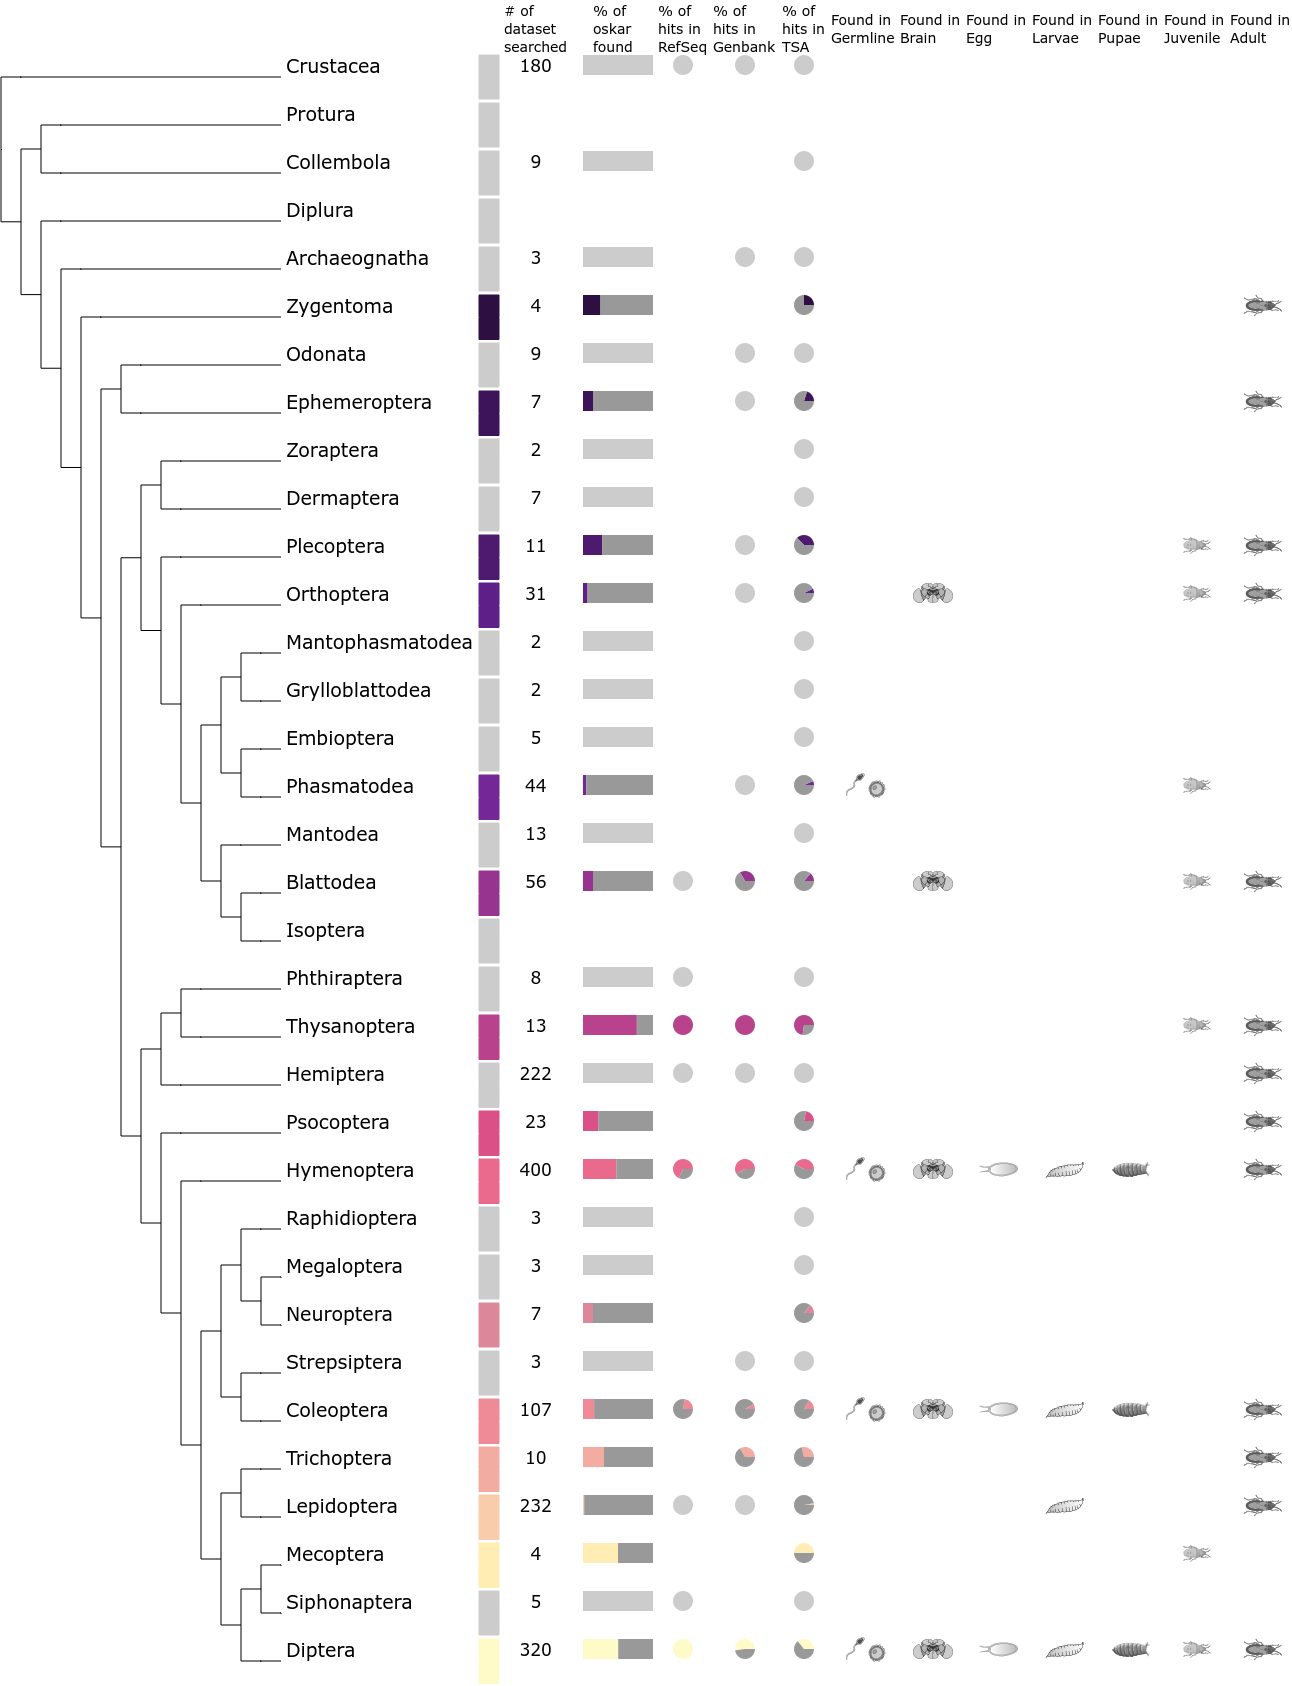

In [40]:

misof_tree.render("%%inline", tree_style=ts)  


In [41]:
misof_tree.render("../Figures/RAW/Fig3_tree.svg", w=183, units="mm", tree_style=ts)  


{'faces': [[143.53684683440713,
   799.490199325911,
   193.22267843093266,
   811.5352494099172,
   64,
   'Mecoptera'],
  [240.14818604987346,
   800.2430149561613,
   250.68760487337886,
   811.786187953334,
   64,
   None],
  [240.14818604987346,
   811.5352494099172,
   250.68760487337886,
   823.0784224070898,
   64,
   None],
  [266.2457945652202,
   799.9920764127446,
   271.7664425203897,
   811.0333723230835,
   64,
   '4'],
  [292.34340308056693,
   800.2430149561613,
   327.97667624575195,
   810.7824337796668,
   64,
   None],
  [398.23946840245475,
   800.2430149561613,
   408.77888722596015,
   810.7824337796668,
   64,
   None],
  [590.709331203137,
   799.2392607824942,
   610.7844146764807,
   811.786187953334,
   64,
   None],
  [143.53684683440713,
   365.8683963016881,
   216.81090151211146,
   377.9134463856943,
   29,
   'Grylloblattodea'],
  [240.14818604987346,
   366.6212119319385,
   250.68760487337886,
   378.16438492911107,
   29,
   None],
  [240.148186049

# Supp figure Lepidoptera loss of oskar

In [16]:
lepi_metadatas = search_metadata[search_metadata['order_name'] == 'Lepidoptera'].groupby(['family_name', 'source'], as_index=False).count()
lepi_metadatas['filtered_hits'] = search_metadata[search_metadata['order_name'] == 'Lepidoptera'].groupby(['family_name', 'source'], as_index=False).sum()['filtered_hits']
lepi_metadatas['found_prop'] = lepi_metadatas['filtered_hits']/lepi_metadatas['index']

In [17]:
def pie_face(node, source, col):
    tmp = lepi_metadatas[lepi_metadatas['source'] == source]
    if node.name in tmp['family_name'].values:
        prop = tmp[tmp['family_name'] == node.name]['found_prop'].values[0]
        count = tmp[tmp['family_name'] == node.name]['filtered_hits'].values[0]
        color = colormap.order("Lepidoptera")
        percents = [min(100*prop, 100), max(0, (1-prop)*100)]
        if prop != 0:
            colors = [color, colormap.gray]
            text_color = "black"
        else:
            colors = [color, colormap.light_gray]
            text_color = colormap.gray
        F = ete3.PieChartFace(percents, 20, 20, colors=colors, line_color=None)
        F.margin_left = 5
        F.hz_align=1
        ete3.faces.add_face_to_node(F, node, col, aligned=True)
        T = ete3.TextFace("{} | {}%".format(int(count), int(min(100*prop, 100))), fgcolor=text_color)
        T.margin_left = 5
        T.hz_align=1
        ete3.faces.add_face_to_node(T, node, col +1 , aligned=True)
    return col + 2
     
def count_face(node, col):
    if node.name in lepi_metadatas['family_name'].values:
        tmp = lepi_metadatas.groupby('family_name', as_index=False).sum()

        count = tmp[(tmp['family_name'] == node.name)]['index'].values[0]
        
        T = ete3.TextFace(count, fgcolor='black')
        T.margin_left = 5
        T.hz_align = 1
        ete3.faces.add_face_to_node(T, node, col, aligned=True)
        
    return col + 1

def total_oskar_found_face(node, col):
    if node.name in lepi_metadatas['family_name'].values:
        tmp = lepi_metadatas.groupby('family_name',as_index=False).sum()
        tmp['found_prop'] = tmp['filtered_hits'] / tmp['index']
        prop = tmp[tmp['family_name'] == node.name]['found_prop'].values[0]
        count = tmp[tmp['family_name'] == node.name]['filtered_hits'].values[0]
        if prop != 0:
            color = colormap.order("Lepidoptera")
            colors = [color, colormap.gray]
            percents = [min(100*prop, 100), max(0, (1-prop)*100)]
            text_color = "black"
        else:
            colors = [colormap.light_gray]
            percents = [100]
            text_color = colormap.gray
        F = ete3.StackedBarFace(percents, 70, 20, colors=colors, line_color=None)
        F.margin_left = 15
        F.hz_align=0
        ete3.faces.add_face_to_node(F, node, col, aligned=True)
        T = ete3.TextFace("{} | {}%".format(int(count), int(min(100*prop, 100))), fgcolor=text_color)
        T.margin_left = 5
        T.margin_right = 15        
        T.hz_align=2
        ete3.faces.add_face_to_node(T, node, col + 1 , aligned=True)
    return col + 2
    
def color_code_face(node, col):
    if (lepi_metadatas[lepi_metadatas['family_name'] == node.name]['filtered_hits'].values > 0).any():
        color = colormap.order('Lepidoptera')
    else:
        color = colormap.order('Other')
    F = ete3.RectFace(20, 22, color, color)
    F.margin_left = 5
    F.margin_top=2    
    ete3.faces.add_face_to_node(F, node, col, aligned=True)

    return col + 1

def header(node, text, col):
    # Handlding the headers, we run it once on Crustacea
    if node.name == 'Agathiphagidae':
        T = ete3.TextFace(text, fgcolor="#000000")
        T.hz_align=1
        T.margin_left = 5
        ts.aligned_header.add_face(T, col)

def layout(node):
    if node.is_leaf():
        # Add node name to laef nodes
        N = ete3.AttrFace("name", fsize=14, fgcolor="black")
        N.vt_align = 1
        N.margin_left = 5
        ete3.faces.add_face_to_node(N, node, 0, aligned=True)
        col = 1

        col = color_code_face(node, col)
        
        header(node, "# of\ndataset\nsearched", col)
        col = count_face(node, col)
        
        header(node, "% of \noskar\nfound", col)
        col = total_oskar_found_face(node, col)        
        
        header(node, "% of\nhits in\nRefSeq", col)
        col = pie_face(node, 'GCF', col)
        header(node, "% of\nhits in\nGenbank", col)
        col = pie_face(node, 'GCA', col)
        header(node, "% of\nhits in\nTSA", col)
        col = pie_face(node, 'TSA', col)
        
    nstyle = ete3.NodeStyle()
    nstyle["size"] = 0
    nstyle["fgcolor"] = "black"
    node.set_style(nstyle)

In [18]:
#Define the tree style
ts = ete3.TreeStyle()
ts.show_leaf_name = False
ts.show_branch_length = False
ts.show_branch_support = False
ts.draw_aligned_faces_as_table = True
ts.draw_guiding_lines = True
ts.show_scale = False
ts.scale=10
ts.guiding_lines_type = 0
ts.guiding_lines_color = 'black'
ts.layout_fn = layout

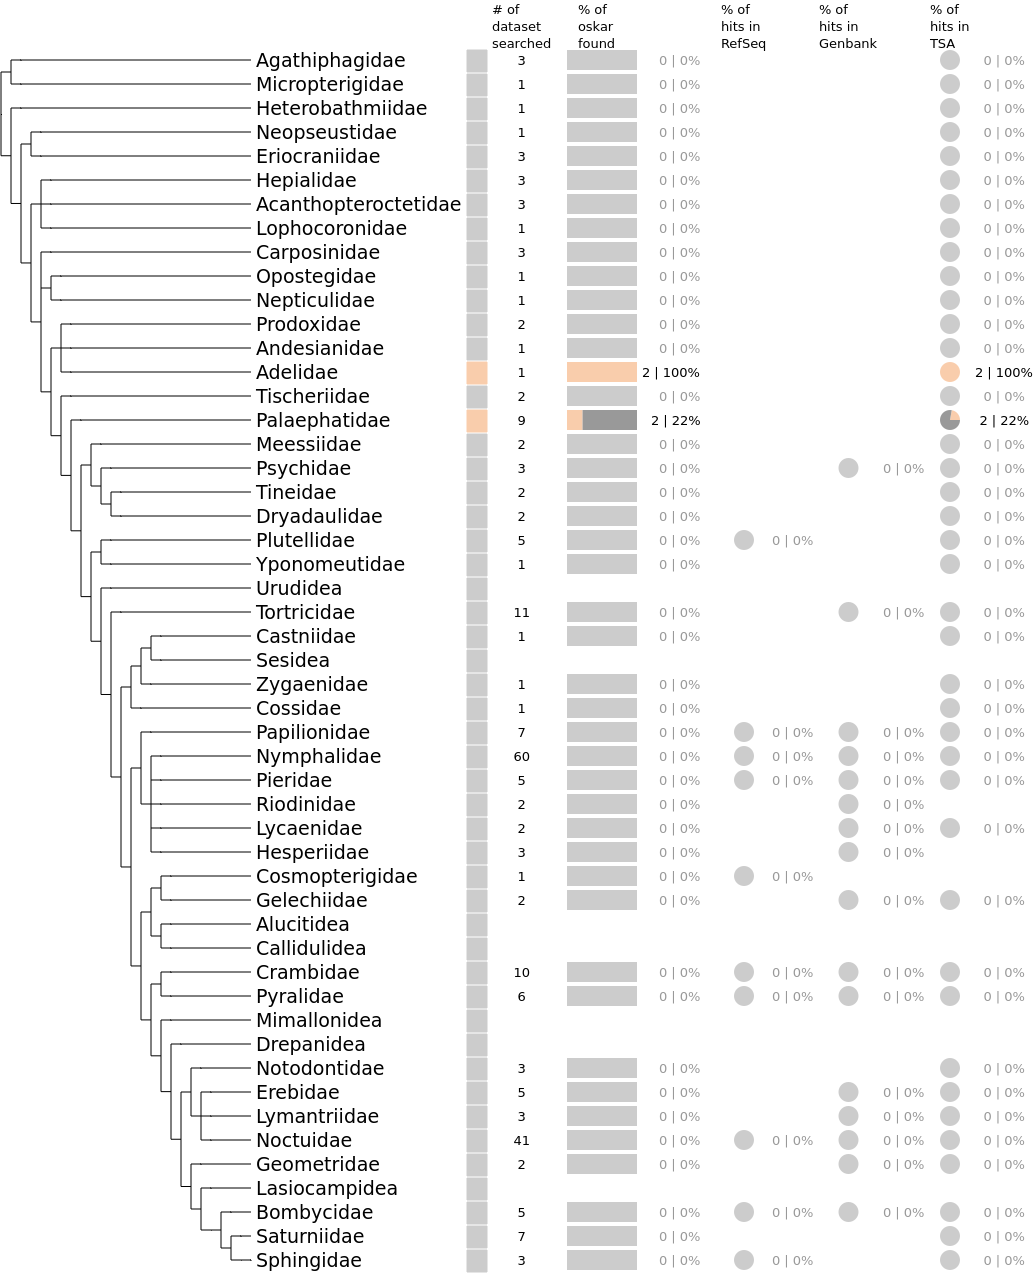

In [19]:
lepidoptera_tree = ete3.Tree('../Data/lepidoptera_phylogeny.newick')
lepidoptera_tree.render("%%inline", tree_style=ts)  

In [21]:
lepidoptera_tree.render("../Figures/RAW/FigS6_tree.svg", w=183, units="mm", tree_style=ts)  

{'nodes': [],
 'faces': [[160.38343016848694,
   59.830537426134775,
   254.35809628283477,
   74.23998623033478,
   2,
   'Agathiphagidae'],
  [292.26121161562173,
   60.45703520023043,
   305.4176648716304,
   74.86648400443043,
   2,
   None],
  [324.2125980945,
   61.71003074842173,
   329.85107806136085,
   72.36049290804782,
   2,
   '3'],
  [354.9109890251869,
   60.45703520023043,
   399.3923309859782,
   73.61348845623912,
   2,
   None],
  [412.8620331290347,
   61.71003074842173,
   439.1749396410521,
   72.36049290804782,
   2,
   '0 | 0%'],
  [588.5946587628652,
   60.45703520023043,
   601.7511120188739,
   73.61348845623912,
   2,
   None],
  [616.1605608230739,
   61.71003074842173,
   642.4734673350912,
   72.36049290804782,
   2,
   '0 | 0%'],
  [160.38343016848694,
   74.86648400443043,
   253.10510073464346,
   89.27593280863043,
   3,
   'Micropterigidae'],
  [292.26121161562173,
   75.49298177852607,
   305.4176648716304,
   89.90243058272608,
   3,
   None],
  [3